In [2]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense,Reshape,Flatten,Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D,UpSampling2D
from keras.layers import BatchNormalization
from keras.optimizers import Adam

Using TensorFlow backend.


In [3]:
from keras.datasets import mnist
(X_train_mnist, Y_train_mnist), (X_test_mnist, Y_test_mnist) = mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


In [0]:
img_shape = X_train_mnist[0].shape

In [5]:
img_shape

(28, 28)

## Generator

In [0]:
noise_size = 100

In [7]:
generator = Sequential()
generator.add(Dense(256,input_dim=noise_size))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(512))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(1024))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Dense(np.prod(img_shape),activation='relu'))
generator.add(Reshape((28,28,1)))
generator.add(Conv2D(32,(3,3),activation='relu',padding='same'))
generator.add(Conv2D(1,(3,3),activation='tanh',padding='same'))
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
__________

## Discriminator

In [8]:
discriminator = Sequential()
discriminator.add(Flatten(input_shape=(28,28,1)))
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dense(1,activation='sigmoid'))
adam = Adam(0.0002, 0.5)
discriminator.compile(loss='binary_crossentropy',optimizer=adam,metrics=['accuracy'])
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________


## GAN

In [0]:
discriminator.trainable = False
gan = Sequential()
gan.add(generator)
gan.add(discriminator)
gan.compile(loss='binary_crossentropy',optimizer=adam)

## Data normalization

In [0]:
X_train_mnist_scaled = ( X_train_mnist-127.5)/127.5
X_test_mnist_scaled = (X_test_mnist-127.5)/127.5

In [11]:
X_test_mnist_scaled.shape

(10000, 28, 28)

In [0]:
X_train_mnist_reshaped = X_train_mnist_scaled[:,:,:,np.newaxis]
X_test_mnist_reshaped = X_test_mnist_scaled[:,:,:,np.newaxis]

In [13]:
X_train_mnist_reshaped.shape

(60000, 28, 28, 1)

In [0]:
Epochs = 10
batch_size = 32
batches = X_train_mnist_reshaped.shape[0]//batch_size
noise_size = 100

In [15]:
for e in range(1,Epochs+1):
  print('-'*15,'Epoch %d' %e,'-'*15)
  for batch in range(batches):
    # Generate fake MNIST images
    noise = np.random.normal(0,1,size=[batch_size,noise_size])
    gen_images = generator.predict(noise)
    
    # Get a random set of input noise and images
    batch_idx = np.random.randint(0,X_train_mnist_reshaped.shape[0],batch_size)
    batch_images = X_train_mnist_reshaped[batch_idx]
    
    images = np.concatenate([batch_images,gen_images])
    
    # Correct labels for generated and real data
    yDis = np.zeros(2*batch_size)
    yDis[:batch_size] = 1
        
    #Train discriminator
    discriminator.trainable = True
    dloss = discriminator.train_on_batch(images,yDis)
    
    #Train generator
    discriminator.trainable = False
    yGen = np.ones(batch_size)
    noise = np.random.normal(0,1,size=[batch_size,noise_size])
    gloss = gan.train_on_batch(noise,yGen)
    
  print("Discriminator loss: %s, generator loss: %s" % (dloss, gloss))

--------------- Epoch 1 ---------------
Discriminator loss: [0.63272166, 0.640625], generator loss: 0.9057425
--------------- Epoch 2 ---------------
Discriminator loss: [0.6587454, 0.65625], generator loss: 1.1175314
--------------- Epoch 3 ---------------
Discriminator loss: [0.65789413, 0.609375], generator loss: 0.8479421
--------------- Epoch 4 ---------------
Discriminator loss: [0.6986358, 0.578125], generator loss: 0.65653646
--------------- Epoch 5 ---------------
Discriminator loss: [0.5856315, 0.6875], generator loss: 1.0477909
--------------- Epoch 6 ---------------
Discriminator loss: [0.5910634, 0.71875], generator loss: 1.0045357
--------------- Epoch 7 ---------------
Discriminator loss: [0.63360757, 0.640625], generator loss: 0.8722392
--------------- Epoch 8 ---------------
Discriminator loss: [0.6731504, 0.609375], generator loss: 0.804885
--------------- Epoch 9 ---------------
Discriminator loss: [0.669529, 0.59375], generator loss: 0.9150279
--------------- Epoch 

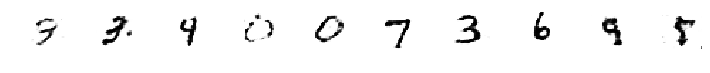

In [39]:
examples=10
dim=(10, 10)
figsize=(10, 10)
noise = np.random.normal(0, 1, size=[examples, noise_size])
generatedImages = generator.predict(noise)

plt.figure(figsize=figsize)
for i in range(generatedImages.shape[0]):
    plt.subplot(dim[0], dim[1], i+1)
    plt.imshow(generatedImages[i, :,:,0], interpolation='nearest', cmap='gray_r')
    plt.axis('off')
plt.tight_layout()
plt.show()